In [29]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf
from isca_tools.thesis.profile_fitting import get_lnb_lev_ind, get_mse_env, interp_var_to_pnorm, get_p_from_pnorm, get_pnorm
from isca_tools.utils.xarray import convert_ds_dtypes
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
path_processed = '/Users/joshduffield/Desktop/ds_mse_env.nc'
load_processed = os.path.exists(path_processed)
if load_processed:
    ds = xr.open_dataset(path_processed)
    ds = ds.load()
    ds['P'] = cesm.get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm)

In [5]:
if not load_processed:
    data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_quant'
    quant_type = 'REFHT_quant99'
    exp_name = ['pre_industrial', 'co2_2x']
    co2_vals = [1, 2]
    n_exp = len(exp_name)
    var_keep = ['T', 'Q', 'Z3', 'PS', 'P0', 'hyam', 'hybm']
    ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], quant_type, 'output.nc'))[var_keep] for i in range(n_exp)]
    ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))
    p0 = float(ds.P0.isel(co2=0))
    ds = ds.drop_vars('P0')
    ds.attrs['P0'] = p0
    ds['hyam'] = ds.hyam.isel(co2=0)
    ds['hybm'] = ds.hybm.isel(co2=0)

In [6]:
if not load_processed:
    ds['P'] = cesm.get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm)
    ds['TREFHT'] = ds.T.isel(lev=-1)
    ds['QREFHT'] = ds.Q.isel(lev=-1)
    ds['ZREFHT'] = ds.Z3.isel(lev=-1)
    ds['PREFHT'] = ds.P.isel(lev=-1)
    ds = ds.drop_vars('Q')

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

I consider two empirical methods:
1. Potential temperature deviation from surface exceeds threshold.
2. This plus additional requirement that lapse rate in the model layer is below a threshold.

In [7]:
%%time

def find_lcl_empirical2(temp_env, p_env, z_env, temp_start=None, p_start=None, temp_pot_thresh=2,
                        temp_pot_thresh_lapse=0.5, lapse_thresh=8.5):
    # Find the lowest model layer with lapse rate less than lapse_thresh
    # LCL is the level at which the pot temp drops by 0.5K within this layer
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)

    # First mask is pot temp close to surface pot temperature
    temp_pot_start = potential_temp(temp_start, p_start)
    mask_temp = np.abs(temp_pot_env - temp_pot_start) <= temp_pot_thresh

    # Second mask is lapse rate close to dry adiabat
    # lower is so append high value at surface
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)  # make same shape
    lapse = lapse.fillna(lapse_thresh + 5)  # ensure final value satisfies lapse criteria
    mask_lapse = lapse > lapse_thresh
    mask = (mask_temp & mask_lapse)
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).min(dim='lev')).astype(int)

    p_low = np.log10(p_env.isel(lev=lcl_ind))  # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind - 1))  # further from surface

    # print(p_low)
    # print(p_high)
    # print(np.log10(p_env))

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind - 1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_low + temp_pot_thresh_lapse
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_target = p_target.clip(min=p_high)
    p_lcl = 10 ** p_target
    # print(dry_profile_temp(temp_start, p_start, p_lcl))
    # print(lapse.isel(lev=lcl_ind-1))
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)

if not load_processed:
    lcl_method = 'physical'
    # lcl_use = 'empirical2'
    if lcl_method == 'physical':
        ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PREFHT)
    elif lcl_method == 'empirical2':
        ds['p_lcl'], ds['T_lcl'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3)
    ds['Z_at_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)
    ds['T_at_lcl'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl)
    ds['mse_sat_at_lcl'] = moist_static_energy(ds['T_at_lcl'], sphum_sat(ds['T_at_lcl'], ds['p_lcl']), ds['Z_at_lcl'])
    ds['lnb_ind'] = get_lnb_lev_ind(ds.T, ds.Z3, ds.P)
    ds.attrs['lcl_method'] = lcl_method

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.06 µs


In [8]:
%%time
if not load_processed:
    p_ft = 500 * 100
    ds['T_ft'] = get_var_at_plev(ds.T, ds.P, p_ft)
    ds['Z_ft'] = get_var_at_plev(ds.Z3, ds.P, p_ft)
    ds['mse_sat_ft'] = moist_static_energy(ds['T_ft'], sphum_sat(ds['T_ft'], p_ft), ds['Z_ft'])
    ds.attrs['p_ft'] = float(p_ft)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


In [9]:
if not load_processed:
    pbar = tqdm(total=2)
    mse_env_pnorm_dict = {}
    # Compute MSE environmental profile (separate above and below LCL)
    mse_env_use = get_mse_env(ds.T, ds.P, ds.Z3, ds.T_at_lcl, ds.p_lcl, prof_type='below_lcl')
    # Interpolate onto p_norm grid
    mse_env_pnorm_dict['below'] = interp_var_to_pnorm(mse_env_use, ds.P, mse_env_use.isel(lev=-1),
                                                      ds.P.isel(lev=-1), ds.mse_sat_at_lcl, ds.p_lcl, ds.lnb_ind)
    pbar.update(1)

    mse_env_use = get_mse_env(ds.T, ds.P, ds.Z3, ds.T_at_lcl, ds.p_lcl, prof_type='above_lcl')
    mse_env_pnorm_dict['above'] = interp_var_to_pnorm(mse_env_use, ds.P, ds.mse_sat_at_lcl, ds.p_lcl,
                                                      ds.mse_sat_ft, p_ft, ds.lnb_ind)
    pbar.update(1)
    pbar.close()
    ds['mse_env'] = xr.concat([mse_env_pnorm_dict['below'][0], mse_env_pnorm_dict['above'][0]],
                              dim=xr.DataArray(['below', 'above'], dims='layer', name='layer'))
    ds['mse_env_n_extrapolate'] = xr.concat([mse_env_pnorm_dict['below'][1], mse_env_pnorm_dict['above'][1]],
                                            dim=xr.DataArray(['below', 'above'], dims='layer', name='layer'))
    del mse_env_use

In [10]:
# Save ds for future use
if not load_processed:
    save_processed = True
    ds = ds.drop_vars('P')          # large memory and quick to compute so drop
    ds = convert_ds_dtypes(ds)
    comp_level = 4
    ds_path = '/Users/joshduffield/Desktop/ds_mse_env.nc'
    if (not os.path.exists(ds_path)) and save_processed:
        ds.to_netcdf(ds_path, format="NETCDF4",
                     encoding={var: {"zlib": True, "complevel": comp_level} for var in ds.data_vars})

In [11]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)

In [12]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

### Individual Locations
Below, I look at the LCL applied to a specific location, to visualize the difference to the physical LCL.

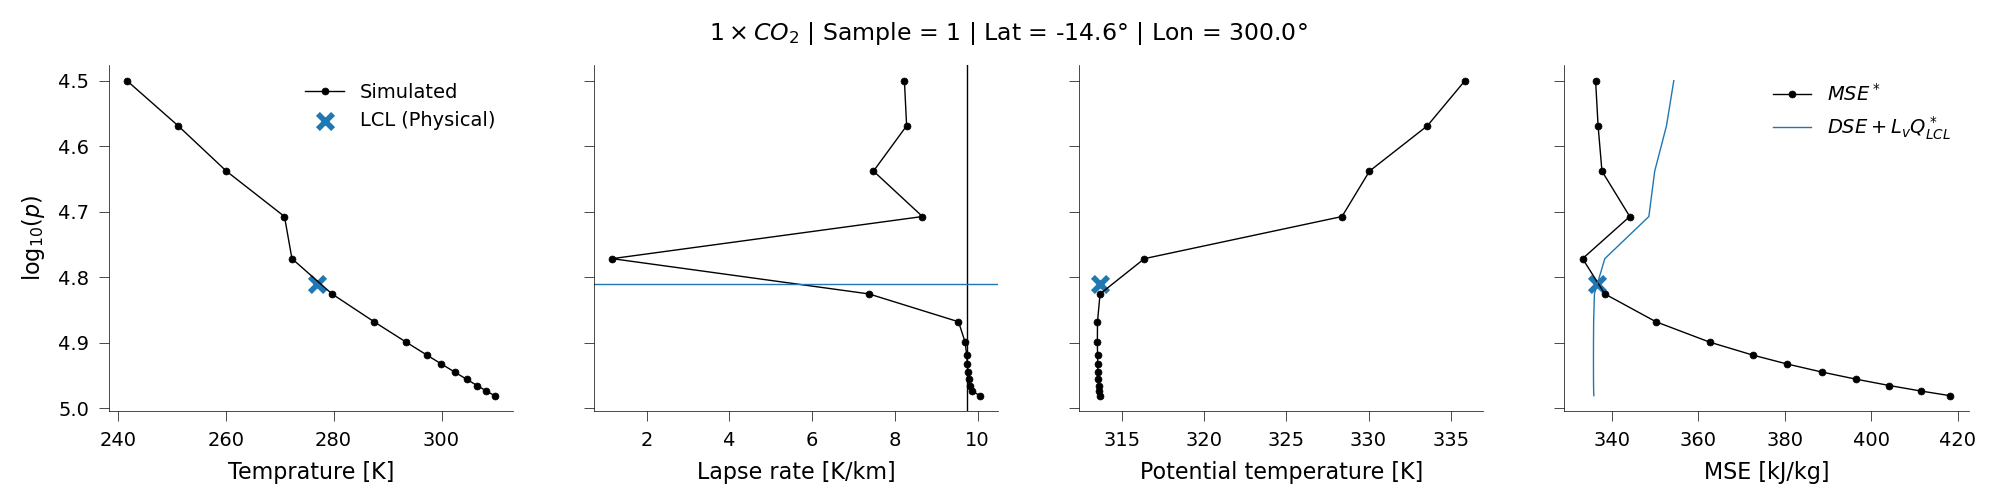

In [14]:
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320, method='nearest')  # Amazon 1
ds_use = ds.isel(co2=0).sel(lat=-15, lon=300, method='nearest')  # Amazon 2
# ds_use = ds.isel(co2=1).sel(lat=3, lon=15, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=3, lon=20, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=50, lon=25, method='nearest')        # Europe
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Canada
# ds_use = ds.isel(co2=1).sel(lat=35, lon=100, method='nearest')        # Tibet
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50, method='nearest')      # Pursian Gulf
# ds_use = ds.isel(co2=0, sample=1).sel(lat=28, lon=50, method='nearest')       # Pursian Gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=35, lon=260, method='nearest')
sample = 0
ds_use = ds_use.isel(sample=sample)
ds_use['lapse_rate'] = -ds_use.T.diff(dim='lev', label='upper') / ds_use.Z3.diff(dim='lev', label='upper') * 1000
ds_use['mse_sat'] = moist_static_energy(ds_use.T, sphum_sat(ds_use.T, ds_use.P), ds_use.Z3)
show_lnb = False
if show_lnb:
    p_max = 30 * 100
else:
    p_max = 300 * 100

fig, ax = plt.subplots(1, 4, sharey=True)
fig_resize(fig, 12)
ax[0].plot(ds_use.T.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

x_var = ds_use['lapse_rate'].where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
y_var = np.log10(ds_use.P).isel(lev=slice(1, 999999)).where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
ax[1].plot(x_var, y_var, marker='o', color='k')
ax[1].axvline(lapse_dry * 1000, color='k')

ds_use['T_pot'] = potential_temp(ds_use.T, ds_use.P)
ax[2].plot(ds_use.T_pot.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

# Add LCL info
# var = find_lcl_empirical2(ds_use.T, ds_use.P, ds_use.Z3)
# var = find_lcl_empirical(ds_use.T, ds_use.P)
ax[0].scatter(ds_use.T_lcl, np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', label='LCL (Physical)')
# ax[0].scatter(ds_use.T_lcl_emp, np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', label='LCL (Empirical)')
# ax[0].scatter(ds_use.T_lcl_emp2, np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2',
#               label='LCL (Empirical 2)')
ax[1].axhline(np.log10(ds_use.p_lcl), color='C0')
# ax[1].axhline(np.log10(ds_use.p_lcl_emp), color='C1')
# ax[1].axhline(np.log10(ds_use.p_lcl_emp2), color='C2')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0')
# ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2,
#               color='C1')
# ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2,
#               color='C2')

ax[3].plot(ds_use.mse_sat.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='$MSE^*$')
for i, key in enumerate(['_lcl']):
    ds_use['mse_qrefht'] = moist_static_energy(ds_use.T, sphum_sat(ds_use[f'T_at{key}'], ds_use[f'p{key}']), ds_use.Z3)
    # ds_use['mse_qrefht'] = moist_static_energy(ds_use.T, ds_use.QREFHT, ds_use.Z3)
    ax[3].plot(ds_use.mse_qrefht.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), color=f'C{i}',
               label='$DSE + L_v Q^*_{LCL}$' if i == 0 else None)
    ax[3].scatter(moist_static_energy(ds_use[f'T_at{key}'], sphum_sat(ds_use[f'T_at{key}'], ds_use[f'p{key}']),
                                      ds_use[f'Z_at{key}']),
                  np.log10(ds_use[f'p{key}']), marker='x', s=30, lw=2, color=f'C{i}')
ax[3].set_xlabel('MSE [kJ/kg]')

if show_lnb:
    ax[0].scatter(ds_use.T.isel(lev=ds_use.lnb_ind), np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)), marker='_', s=400,
                  lw=1, color='C0')

ax[0].invert_yaxis()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temprature [K]')
ax[1].set_xlabel('Lapse rate [K/km]')
ax[2].set_xlabel('Potential temperature [K]')
ax[0].legend()
ax[3].legend()
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$",
    fontsize=8.5)
plt.show()

### Size of layer above LCL and below FT level
Next, we want to consider the temperature profile above the LCL but below the LNB level. The minimum size of this layer is approx $p_{LCL}/p_{LNB} = 10^{0.45} = 2.82$, as shown below.

So for an LCL at sea level pressure of 1000hPa, the LNB would be about 350hPa, as shown below.

354.81338923357526


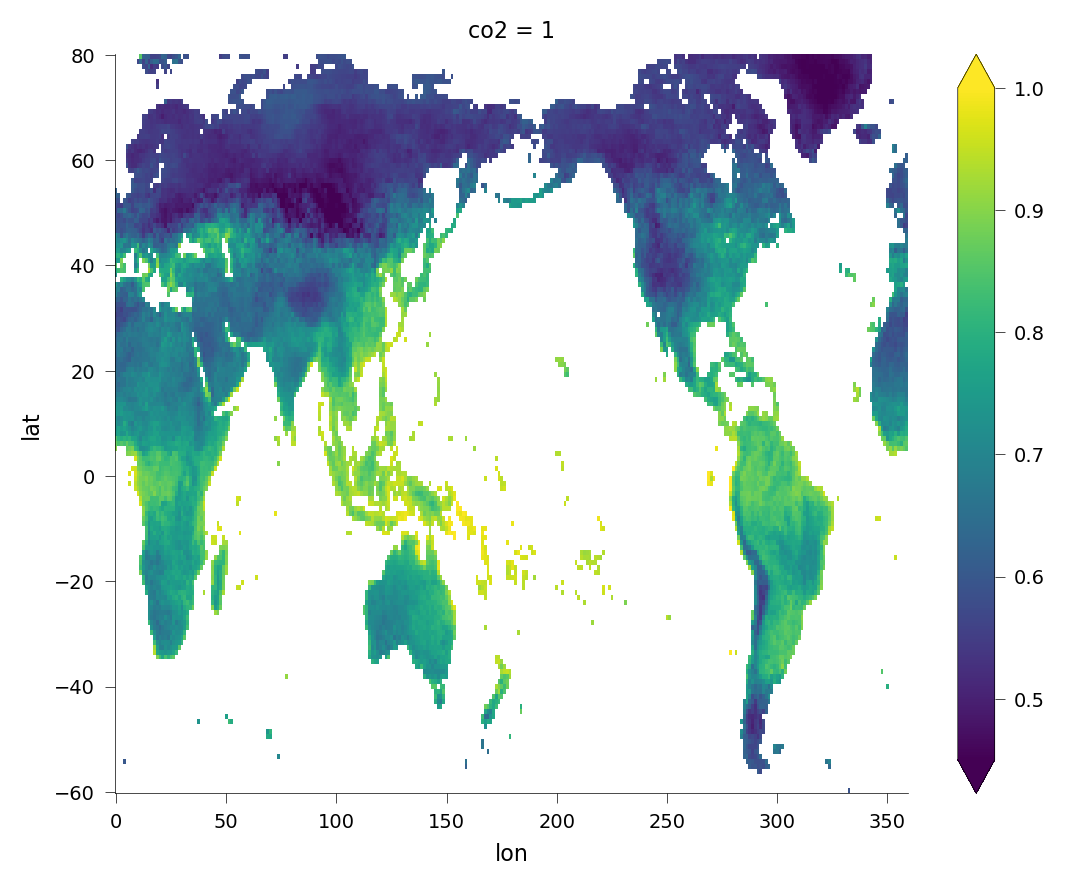

In [15]:
(np.log10(ds.p_lcl) - np.log10(ds.P.isel(lev=ds.lnb_ind))).isel(co2=0).mean(dim='sample').where(lsm).sel(
    lat=slice(-60, 80)).plot(
    vmin=0.45, vmax=1)
print(10 ** (np.log10(1000 * 100) - 0.45) / 100)

### Interpolation in region between LCL and LNB
The temperature profiles show pretty uniform lapse rates when plotted against $\log_{10}(p)$, so we want a grid uniform in this space.

I.e. we want to go from $\log_{10}(p_{LCL}) - \log_{10}(p) = 0$ to $0.45$ in equal steps e.g. 0.05.

In the example, we show in blue the profile used above between LCL and LNB for this region. The pressure levels marked as above LNB are not used to characterize the profile because they are in a different (stratospheric) regime.

In [30]:
pnorm_use = get_pnorm(ds_use.P, ds_use.P.isel(lev=-1), ds_use.p_lcl)
pnorm_use = pnorm_use.where(pnorm_use<1, get_pnorm(ds_use.P, ds_use.p_lcl, ds_use.p_ft) + 1)

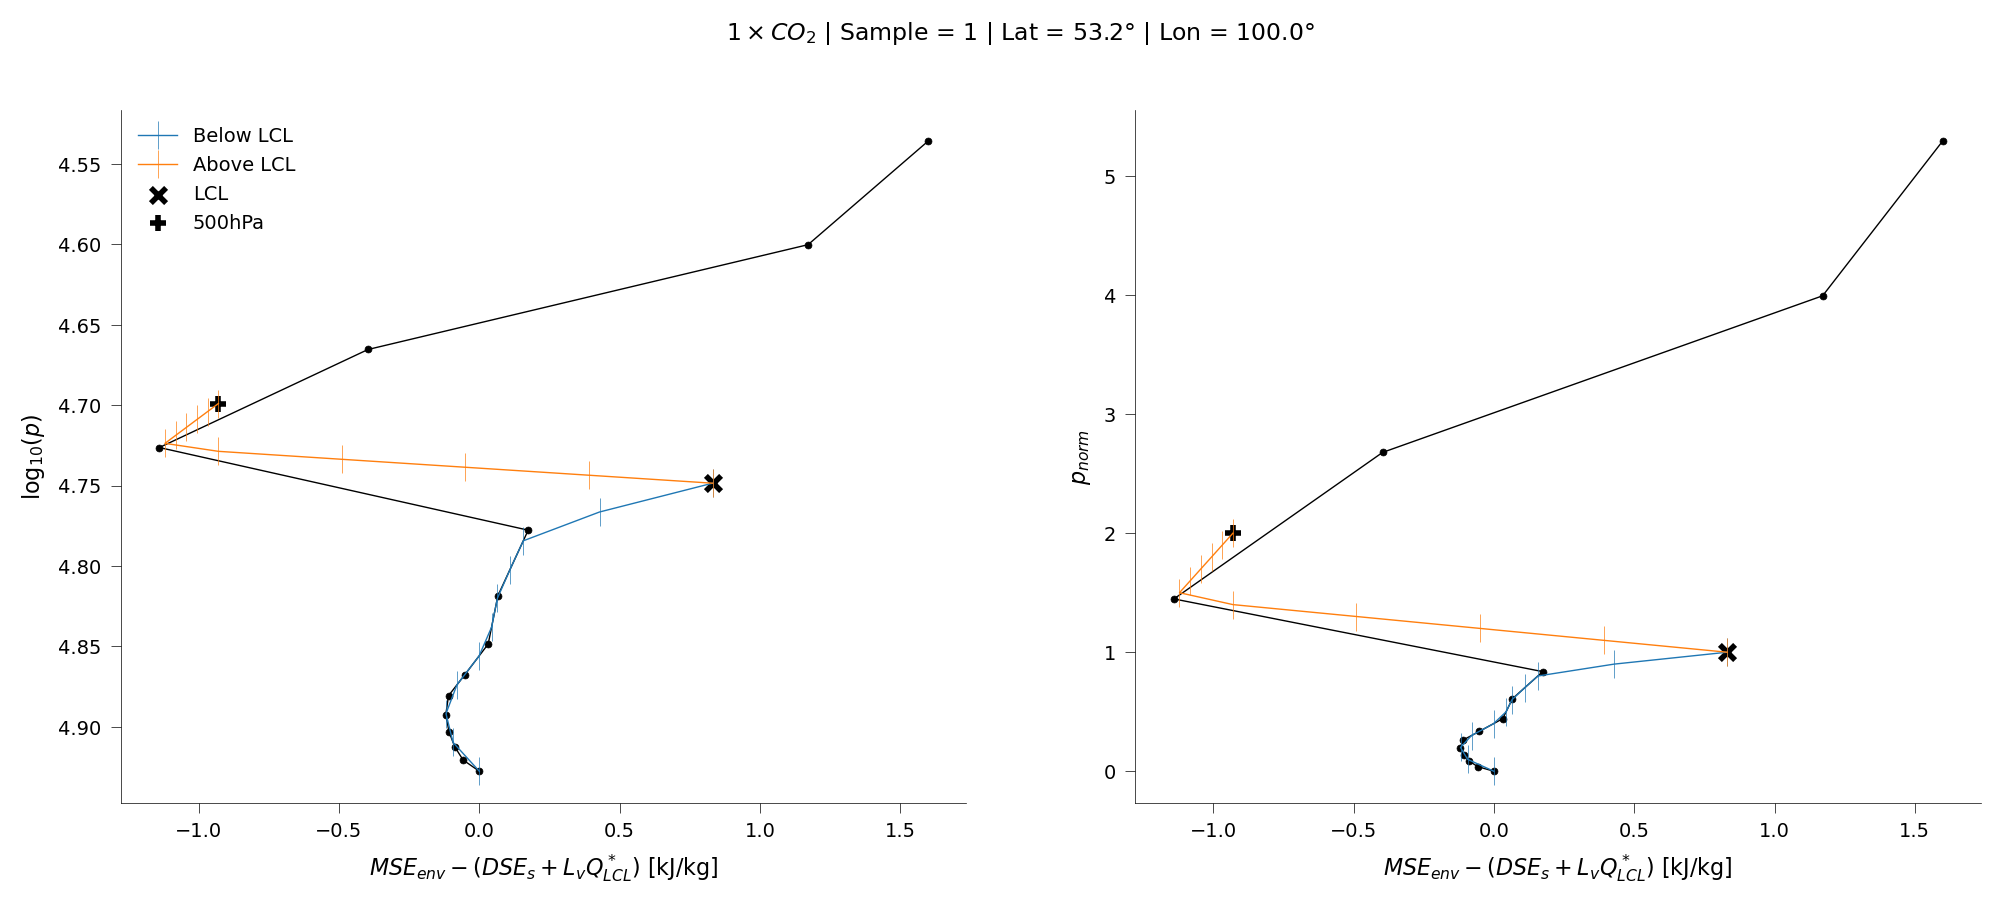

In [46]:
# logp_grid = np.append(np.arange(0, 0.06, 0.01), np.arange(0.0525, 0.45 + 0.025, 0.025))  # finer close to LCL
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320, method='nearest')
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300, method='nearest')  # Amazon 2
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')  # Persian gulf
# ds_use = ds.isel(co2=0).sel(lat=28, lon=50, method='nearest')  # Persian gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=-85, lon=100, method='nearest')       # Antarctic, hard test
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Small inversion near LCL
# ds_use = ds.isel(co2=0).sel(lat=-35, lon=125, method='nearest')       # Very big inversion at Ocean near Australia
# ds_use = ds.isel(co2=0).sel(lat=51, lon=90, method='nearest')         # Tibet, inversion type behaviour well above LCL
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
ds_use = ds_use.isel(sample=0)

p_max = 30 * 100
p_max = 300 * 100

fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 12)

mse_prof_use = {key: get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl, ds_use.p_lcl, key)
                for key in ['full', 'above_lcl', 'below_lcl']}
ax[0].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           np.log10(ds_use.P).where(ds_use.P >= p_max), color='k', marker='o')
xlim_use = ax[0].get_xlim()
ax[0].plot(ds_use.mse_env.isel(layer=0),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.P.isel(lev=-1), ds_use.p_lcl)),
           color='C0', label='Below LCL', marker='|', markersize=10)
ax[0].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.p_lcl, ds_use.p_ft)),
           color='C1', label='Above LCL', marker='|', markersize=10)
ax[0].set_xlim(xlim_use)
ax[0].scatter(ds_use.mse_sat_at_lcl - mse_prof_use['full'].isel(lev=-1), np.log10(ds_use[f'p_lcl']), color='k', marker='x', s=30,
              lw=2, label='LCL')
ax[0].scatter(ds_use.mse_sat_ft - mse_prof_use['full'].isel(lev=-1), np.log10(ds.p_ft), color='k', marker='+', s=30, lw=2,
              label=f'{ds.p_ft / 100:.0f}hPa')
# ax[0].axhline(np.log10(p_ft), color='k', lw=ax_linewidth, label=f'{p_ft/100:.0f}hPa')
ax[0].invert_yaxis()

pnorm_use = get_pnorm(ds_use.P, ds_use.P.isel(lev=-1), ds_use.p_lcl)
pnorm_use = pnorm_use.where(pnorm_use<1, get_pnorm(ds_use.P, ds_use.p_lcl, ds_use.p_ft) + 1)
ax[1].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           pnorm_use.where(ds_use.P >= p_max), color='k', marker='o')
ax[1].plot(ds_use.mse_env.isel(layer=0), ds_use.pnorm, marker='|', markersize=10, color='C0')
ax[1].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), ds_use.pnorm+1, marker='|', markersize=10, color='C1')
ax[1].scatter(ds_use.mse_env.isel(layer=0).sel(pnorm=1), 1, color='k', marker='x', s=30, lw=2)
ax[1].scatter(ds_use.mse_env.isel(layer=1).sel(pnorm=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), 2, color='k', marker='+', s=30, lw=2)

ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_ylabel('$p_{norm}$')
ax[0].legend()
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$",
    fontsize=8.5)
plt.show()

## PCA


In [20]:
ds_use = ds.isel(co2=0).sel(lat=slice(-60, 80)).isel(sample=0)
var = {'low': interp_var_to_pnorm(ds_use.T, ds_use.P, ds_use.T.isel(lev=-1), ds_use.PREFHT, ds_use[f'T_at{lcl_use}'],
                                  ds_use[f'p{lcl_use}'], ds_use.lnb_ind),
       'high': interp_var_to_pnorm(ds_use.T, ds_use.P, ds_use[f'T_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.T_ft,
                                   p_ft, ds_use.lnb_ind)}
_, ds_use[f'mse_at{lcl_use}'], ds_use['mse_env_low'], ds_use['mse_env_high'] = get_mse_prof(ds_use.T, ds_use.P,
                                                                                            ds_use.Z3,
                                                                                            ds_use[f'T_at{lcl_use}'],
                                                                                            ds_use[f'p{lcl_use}'],
                                                                                            ds_use[f'Z_at{lcl_use}'])
var2 = {'low': interp_var_to_pnorm(ds_use.mse_env_low, ds_use.P, ds_use.mse_env_low.isel(lev=-1), ds_use.P.isel(lev=-1),
                                   ds_use[f'mse_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind),
        'high': interp_var_to_pnorm(ds_use.mse_env_high, ds_use.P, ds_use[f'mse_at{lcl_use}'], ds_use[f'p{lcl_use}'],
                                    ds_use.mse_sat_ft, p_ft, ds_use.lnb_ind)}

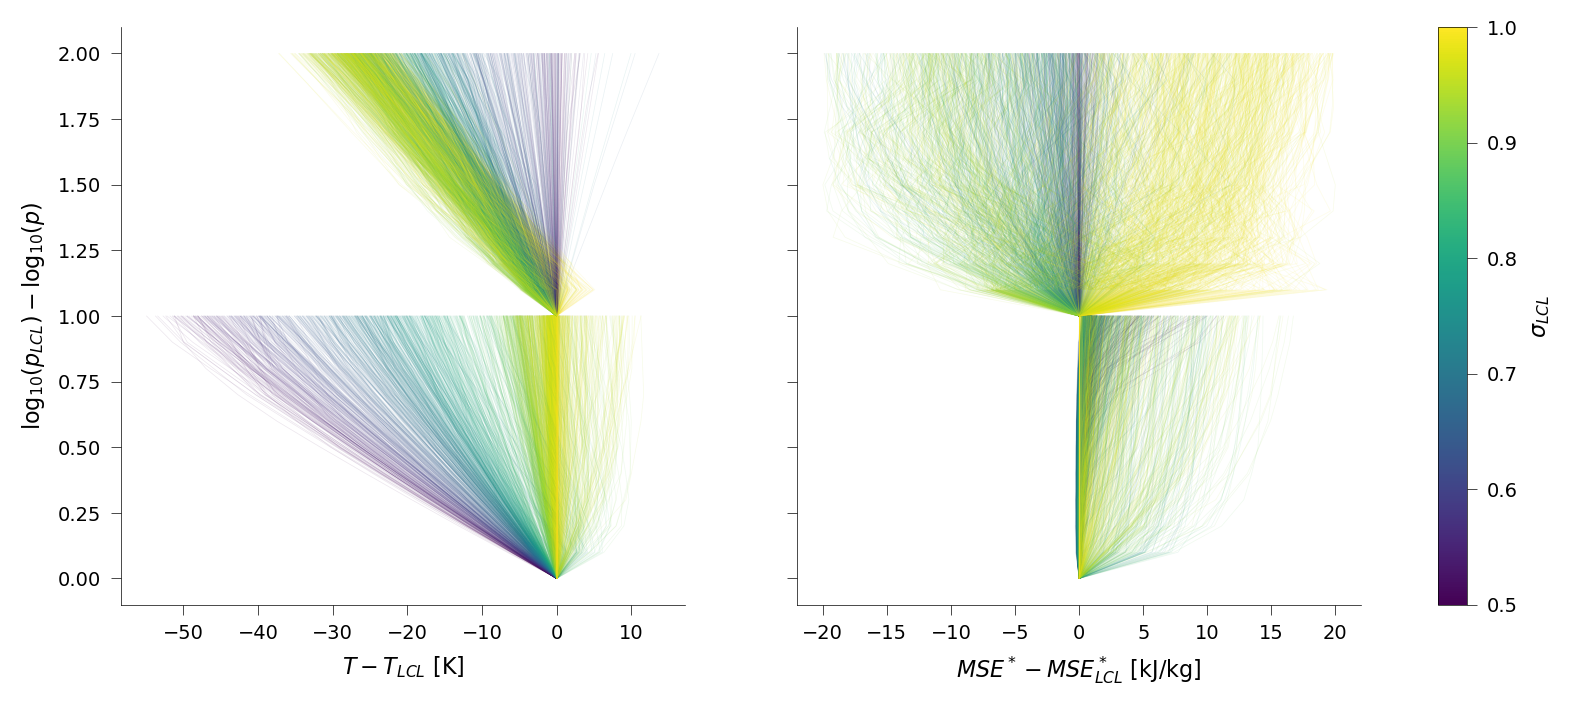

In [21]:
# # Only show lines where max MSE deviation is mse_thresh, and no more than extrap_thresh levels above LNB
mse_thresh = 20
extrap_thresh = 2

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0.5, vmax=1)
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 10)

for i in range(0, ds_use.lat.size, 2):
    for j in range(0, ds_use.lon.size, 3):
        if lsm.isel(lat=i, lon=j):
            for key in ['low', 'high']:
                if var[key][1].isel(lat=i, lon=j) <= extrap_thresh:
                    if np.abs(var2[key][0].isel(lat=i, lon=j)).max() < mse_thresh:
                        ax[0].plot(var[key][0].isel(lat=i, lon=j), var[key][0].pnorm + int(key == 'high'), alpha=0.1,
                                   lw=ax_linewidth,
                                   c=cmap(norm((ds_use[f'p{lcl_use}'] / ds_use.PREFHT).isel(lat=i, lon=j))))
                        ax[1].plot(var2[key][0].isel(lat=i, lon=j), var2[key][0].pnorm + int(key == 'high'), alpha=0.1,
                                   lw=ax_linewidth,
                                   c=cmap(norm((ds_use[f'p{lcl_use}'] / ds_use.PREFHT).isel(lat=i, lon=j))))
ax[0].set_xlabel('$T - T_{LCL}$ [K]')
ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax[0].set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for ScalarMappable
fig.colorbar(sm, ax=ax, label='$\sigma_{LCL}$')
plt.show()

In [23]:
def get_profiles_numpy(profiles: xr.DataArray, valid: Optional[xr.DataArray] = None, lev_name: str = "pnorm"):
    if lev_name not in profiles.dims:
        raise ValueError(f"profiles must have a '{lev_name}' dimension")

    # dims except vertical
    nonlev_dims = [d for d in profiles.dims if d != lev_name]
    if len(nonlev_dims) < 2:
        # still allow any number of non-lev dims (e.g. co2, lat, lon) as long as lev exists
        pass

    # default valid: finite across lev
    if valid is None:
        valid = np.isfinite(profiles).all(dim=lev_name)

    # stack all non-lev dims into a single "points" axis
    stacked = profiles.stack(points=nonlev_dims)  # dims (..., lev_name) -> (points, lev_name) after transpose
    stacked = stacked.transpose("points", lev_name)  # ensure order is (points, lev)

    # flatten valid mask to points
    valid_flat = valid.stack(points=nonlev_dims)
    valid_mask = valid_flat.values.astype(bool)

    X_all = stacked.values  # shape (n_points, n_lev)
    X_valid = X_all[valid_mask, :]  # (n_valid, n_lev)
    return X_all, X_valid


def pca_on_profiles(
        profiles: xr.DataArray,
        n_modes: int = 4,
        standardize: bool = True,
        valid: Optional[xr.DataArray] = None,
        lev_name: str = "pnorm",
        reference_mean: Optional[xr.DataArray] = None,
) -> Tuple[xr.DataArray, xr.DataArray, xr.DataArray, xr.DataArray, np.ndarray, np.ndarray]:
    """
    Perform PCA (via SVD) on vertical profiles enforcing a fixed reference mean
    (e.g. zero). The PCA is fit only on profiles where `valid` is True, and the
    same components are applied to all profiles in `profiles`.

    Args:
        profiles (xr.DataArray): DataArray with dims (..., lev_name) (e.g. (co2, lat, lon, lev)).
        n_modes (int): Number of PCA modes to keep.
        standardize (bool): If True, divide each level by its std (computed from valid points)
            *before* SVD so that levels with different variances are equalized.
            If False, SVD is performed on raw deviations from `reference_mean`.
        valid (Optional[xr.DataArray]): Boolean mask with the same non-lev dims as `profiles`.
            True indicates the grid cell is used to compute the PCA basis. If None, all
            grid cells with finite values across lev are considered valid.
        lev_name (str): Name of the vertical dimension in `profiles`.
        reference_mean (Optional[xr.DataArray]): 1-D DataArray (dim lev_name) to subtract before SVD.
            If None, a zero reference mean is used (i.e. PCA on deviations from zero).

    Returns:
        components (xr.DataArray): EOFs (modes) with dims ("mode", lev_name).
        scores (xr.DataArray): PC coefficients with dims (all non-lev dims..., "mode").
        mean_profile (xr.DataArray): The reference_mean actually used (dim lev_name).
        std_profile (xr.DataArray): Std used for scaling (dim lev_name). Ones if standardize=False.

    Notes:
        - This function uses np.linalg.svd directly so there is NO automatic re-centering:
          the `reference_mean` you supply (or zero) is the baseline from which deviations
          are computed.
        - If standardize=True, std_profile is computed from the valid set and used both
          for the SVD input and for projecting all profiles.
    """
    # --- checks ---
    if lev_name not in profiles.dims:
        raise ValueError(f"profiles must have a '{lev_name}' dimension")

    # dims except vertical
    nonlev_dims = [d for d in profiles.dims if d != lev_name]
    if len(nonlev_dims) < 2:
        # still allow any number of non-lev dims (e.g. co2, lat, lon) as long as lev exists
        pass

    n_lev = profiles.sizes[lev_name]

    # prepare reference mean (1d array length n_lev)
    if reference_mean is None:
        reference_mean_vals = np.zeros(n_lev)
        # reference_mean_da = xr.DataArray(reference_mean_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    else:
        # allow reference_mean to be xr.DataArray aligned on lev_name
        reference_mean_da = reference_mean.copy()
        if lev_name not in reference_mean_da.dims:
            raise ValueError("reference_mean must have dimension named lev_name")
        # align and extract numeric array in lev order of profiles
        reference_mean_da = reference_mean_da.reindex({lev_name: profiles[lev_name]})
        reference_mean_vals = reference_mean_da.values

    X_all, X_valid = get_profiles_numpy(profiles, valid, lev_name)
    n_valid = X_valid.shape[0]
    if n_valid < (n_modes + 1):
        raise ValueError("Too few valid profiles for PCA; reduce n_modes or check coverage.")

    # subtract reference mean
    Xc_valid = X_valid - reference_mean_vals[None, :]

    # compute std_profile from valid subset if requested
    if standardize:
        std_profile_vals = Xc_valid.std(axis=0, ddof=1)
        # avoid zeros
        std_profile_vals = np.where(std_profile_vals == 0, 1.0, std_profile_vals)
        Xc_valid = Xc_valid / std_profile_vals[None, :]
    else:
        std_profile_vals = np.ones(n_lev)

    # --- SVD on the prepared valid data (no further centering) ---
    # Xc_valid shape: (n_valid, n_lev). compute thin SVD
    U, S, Vt = np.linalg.svd(Xc_valid, full_matrices=False)
    # components (EOFs) are rows of Vt; keep first n_modes
    components_vals = Vt[:n_modes, :]  # (n_modes, n_lev)

    # --- project ALL profiles using same transform ---
    # subtract reference mean and divide by std_profile (if standardize)
    Xc_all = X_all - reference_mean_vals[None, :]
    if standardize:
        Xc_all = Xc_all / std_profile_vals[None, :]

    # scores_all: (n_points, n_modes)
    scores_all = Xc_all @ components_vals.T

    # reshape back to original non-lev dims + mode
    out_shape = [profiles.sizes[d] for d in nonlev_dims] + [n_modes]
    scores_da = xr.DataArray(
        scores_all.reshape(*out_shape),
        dims=nonlev_dims + ["mode"],
        coords={**{d: profiles[d] for d in nonlev_dims}, "mode": np.arange(n_modes)}
    )

    components_da = xr.DataArray(
        components_vals,
        dims=("mode", lev_name),
        coords={"mode": np.arange(n_modes), lev_name: profiles[lev_name]}
    )

    mean_profile_da = xr.DataArray(reference_mean_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    std_profile_da = xr.DataArray(std_profile_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})

    # Variance explained by each mode
    var_explained = (S ** 2) / (Xc_valid.shape[0] - 1)

    # Fractional variance explained
    frac_var_explained = var_explained / var_explained.sum()

    return components_da, scores_da, mean_profile_da, std_profile_da, var_explained[:n_modes], frac_var_explained[
        :n_modes]

In [24]:
ds_use = ds.isel(co2=[0, 1])
# ds_use['mse_env'], ds_use[f'mse_at{lcl_use}'] = get_mse_prof(ds_use.T, ds_use.P, ds_use.Z3,
#                                                              ds_use[f'T_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use[f'Z_at{lcl_use}'])
_, ds_use[f'mse_at{lcl_use}'], ds_use['mse_env_low'], ds_use['mse_env_high'] = get_mse_prof(ds_use.T, ds_use.P,
                                                                                            ds_use.Z3,
                                                                                            ds_use[f'T_at{lcl_use}'],
                                                                                            ds_use[f'p{lcl_use}'],
                                                                                            ds_use[f'Z_at{lcl_use}'])
# var = interp_var_to_pnorm(ds_use.mse_env, ds_use.P, ds_use[f'mse_at{lcl_use}'], ds_use[f'p{lcl_use}'],
#                           ds_use.lnb_ind)
var = {'low': interp_var_to_pnorm(ds_use.mse_env_low, ds_use.P, ds_use.mse_env_low.isel(lev=-1), ds_use.P.isel(lev=-1),
                                  ds_use[f'mse_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind),
       'high': interp_var_to_pnorm(ds_use.mse_env_high, ds_use.P, ds_use[f'mse_at{lcl_use}'], ds_use[f'p{lcl_use}'],
                                   ds_use.mse_sat_ft, p_ft, ds_use.lnb_ind)}
# var = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'],
#                          ds_use.lnb_ind, logp_custom_grid=logp_grid)


In [25]:
valid = {key: (lsm > 0) & (var[key][1] <= 2) & (np.abs(var[key][0]).max(dim='pnorm') <= 20) & (ds_use.lat > -60) & (
            ds_use.lat < 75)
         for key in var}
n_modes = 4
pca_output = {key: list(
    pca_on_profiles(var[key][0].isel(pnorm=slice(1, 9999)), valid=valid[key], standardize=True, n_modes=n_modes)) for
              key in var}

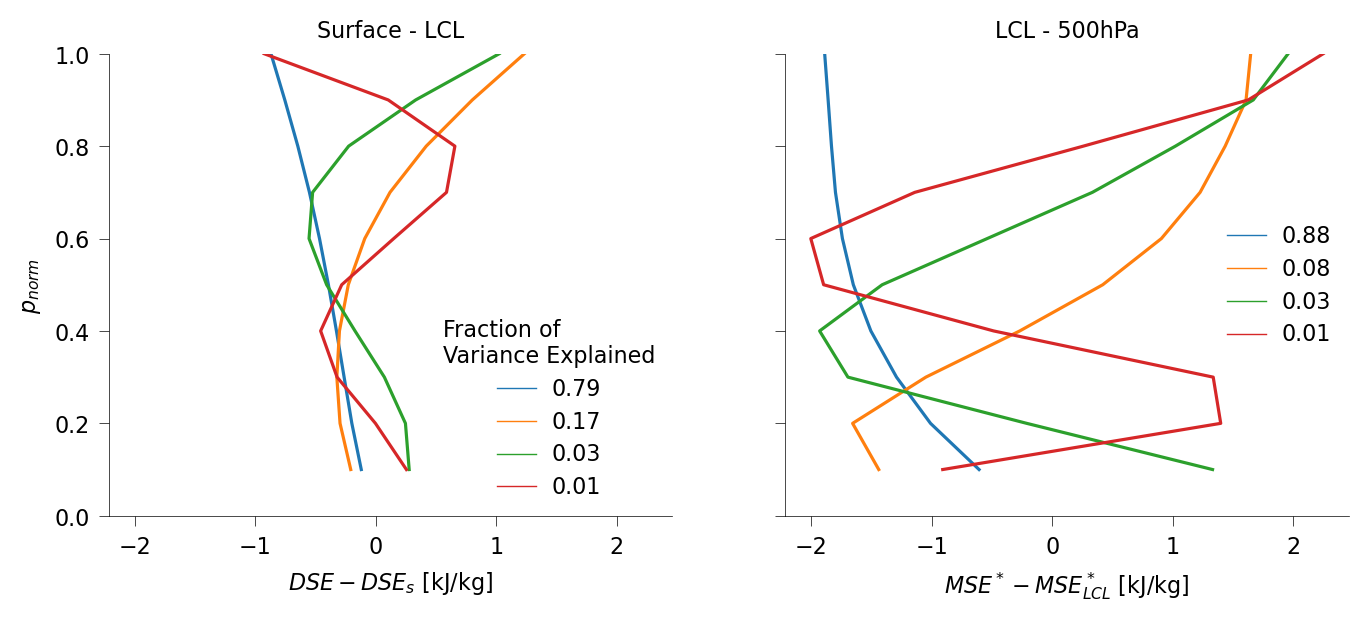

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig_resize(fig, 8)
for j, key in enumerate(pca_output):
    for i in range(n_modes):
        ax[j].plot(pca_output[key][0].isel(mode=i) * pca_output[key][3], var[key][0].isel(pnorm=slice(1, 9999)).pnorm,
                   label=f'{pca_output[key][-1][i]:.2f}', color=f'C{i}')
ax[0].set_xlabel('$DSE - DSE_s$ [kJ/kg]')
ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax[0].legend(title='Fraction of\nVariance Explained')
ax[1].legend()
ax[0].set_ylabel('$p_{norm}$')
ax[0].set_title('Surface - LCL')
ax[1].set_title(f'LCL - {p_ft / 100:.0f}hPa')

ax[0].set_ylim(0, 1)
update_linewidth(fig)
update_fontsize(fig, base_fontsize=7)
plt.show()

In [66]:
def scaled_k_means(x: np.ndarray, initial_cluster_mean: np.ndarray, norm_thresh: float = 1,
                   score_thresh: float = 0.5, score_diff_thresh: float = 0.1,
                   score_diff_thresh_test_converge: float = 0.05, min_cluster_size: int = 10,
                   n_iter: int = 100) -> np.ndarray:
    norm_cluster_mean = initial_cluster_mean / np.linalg.norm(initial_cluster_mean, axis=1).reshape(-1, 1)
    n_modes = initial_cluster_mean.shape[0]
    cluster_eig_val = np.zeros(n_modes)
    cluster_ind = np.full(x.shape[0], -20, dtype=int)
    x_norm = np.linalg.norm(x, axis=1)
    for i in range(n_iter):
        cluster_ind_old = cluster_ind.copy()
        coef = x @ norm_cluster_mean.transpose()  # because each initial_cluster_mean has norm of 1
        x_residual = x[:, :, np.newaxis] - coef[:, np.newaxis] * norm_cluster_mean.transpose()[np.newaxis]
        norm_reduction = (x_norm[:, np.newaxis] - np.linalg.norm(x_residual, axis=1)) / x_norm[:, np.newaxis]
        cluster_ind = norm_reduction.argmax(axis=1)
        cluster_ind[x_norm <= norm_thresh] = -1  # already has low norm, so don't use in updating coefs
        top_score = norm_reduction.max(axis=1)
        high_score = (top_score > score_thresh
                      ) & (top_score - np.partition(norm_reduction, -2, axis=1)[:, -2] > score_diff_thresh)
        # to help terminate
        low_score = top_score - np.partition(norm_reduction, -2, axis=1)[:, -2] < score_diff_thresh_test_converge
        for c in range(n_modes):
            my_points = x[(cluster_ind == c) & high_score]
            n_my_points = my_points.shape[0]
            # print(n_my_points)
            if n_my_points < min_cluster_size:
                norm_cluster_mean[c] = 0
                continue
            # print(n_my_points)
            eig_vals, eigs = np.linalg.eig(my_points.transpose() @ my_points / n_my_points)
            best_eig_ind = np.argmax(eig_vals)
            norm_cluster_mean[c] = eigs[:, best_eig_ind] * np.sign(eigs[:, best_eig_ind].mean())  # make them positive
            cluster_eig_val[c] = eig_vals[best_eig_ind]
        print(i + 1, (cluster_ind[~low_score] != cluster_ind_old[~low_score]).sum())

        if (cluster_ind[~low_score] == cluster_ind_old[~low_score]).all():
            print(f'Done after {i + 1} iter')
            break
    # coef_best = coef[:, np.clip(cluster_ind, 0, n_modes-1)]
    # coef_best[cluster_ind<0] = 0
    return norm_cluster_mean, cluster_eig_val, cluster_ind, top_score, coef[np.arange(x.shape[0]), cluster_ind]

In [67]:
k_output = scaled_k_means(get_profiles_numpy(var[key][0].isel(pnorm=slice(1, 9999)), valid[key])[1],
                          pca_output[key][0].to_numpy())

1 524351
2 1795
3 4978
4 13032
5 14393
6 9587
7 6553
8 44289
9 5013
10 4332
11 5844
12 6304
13 5027
14 2445
15 821
16 273
17 8
18 0
Done after 18 iter


In [72]:
residual = get_profiles_numpy(var[key][0].isel(pnorm=slice(1, 9999)), valid[key])[1] - k_output[-1][:, np.newaxis] * \
           k_output[0][k_output[2]]

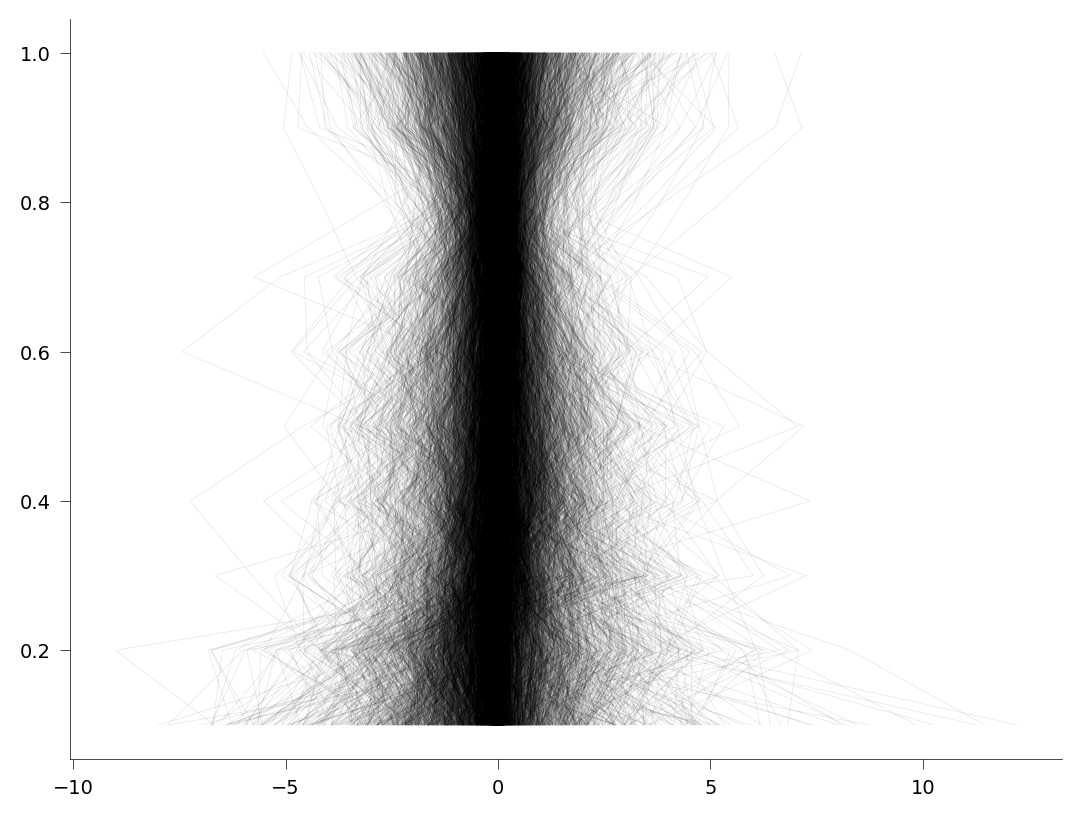

In [76]:
for i in range(0, len(residual), 100):
    plt.plot(residual[i], var[key][0].isel(pnorm=slice(1, 9999)).pnorm, color='k', lw=ax_linewidth, alpha=0.1)

In [81]:
residual.std(axis=0, ddof=1)
pca_residual = np.linalg.svd(residual / residual.std(axis=0, ddof=1), full_matrices=False)[-1]
# components (EOFs) are rows of Vt; keep first n_modes
pca_residual = pca_residual[:n_modes, :]  # (n_modes, n_lev)

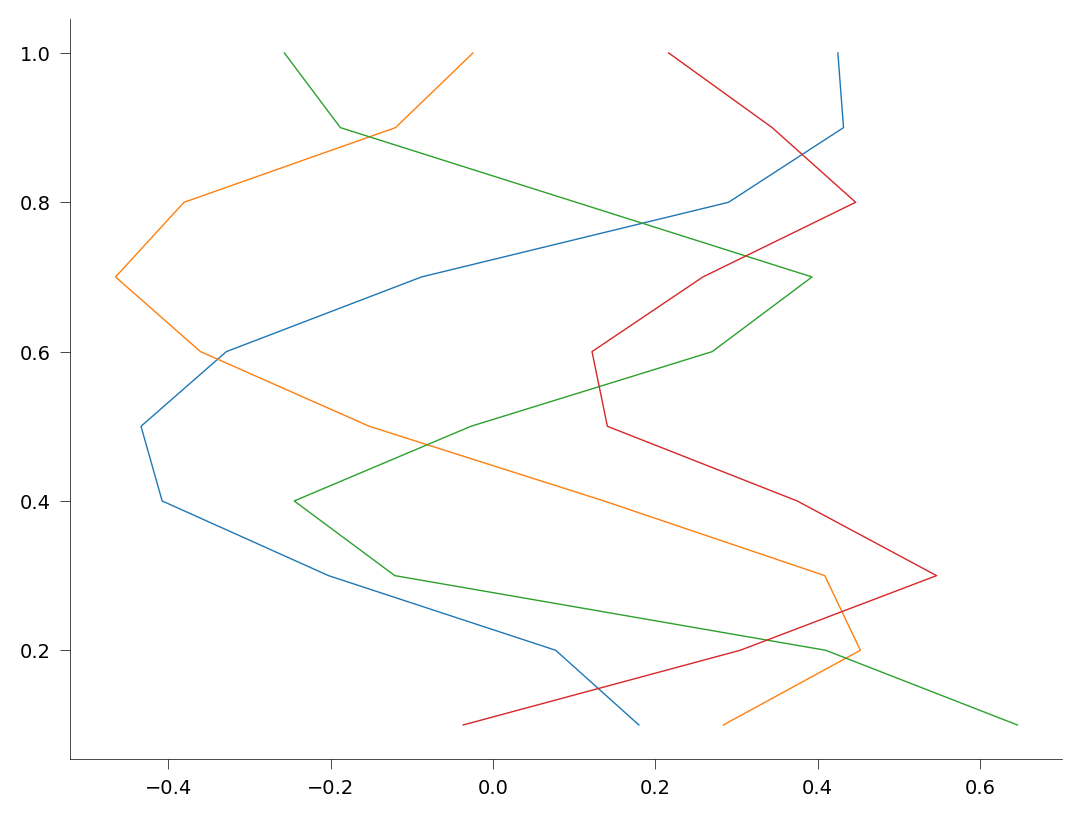

In [83]:
for i in range(0, 4):
    plt.plot(pca_residual[i], var[key][0].isel(pnorm=slice(1, 9999)).pnorm)

In [77]:
pca_output_residual = list(pca_on_profiles(residual, standardize=True, n_modes=n_modes))

AttributeError: 'numpy.ndarray' object has no attribute 'dims'

In [68]:
k_output[-1]

array([ 29.208347  ,  30.38435625,  18.80904566, ...,  50.57245335,
       -22.81474158,  51.03961251])

In [63]:
k_output[-1][:10][np.arange(10), k_output[2][:10]]

array([29.208347  , 30.38435625, 18.80904566, 34.66866424, 29.89511771,
       45.38866597, 21.28417637, 43.86673064, 26.04922801, 19.66903712])

In [50]:
(k_output[2] > 1).sum() / k_output[2].size * 100

23.03435198659435

In [360]:
key = 'high'
norm_thresh = 1
score_thresh = 0.5
score_diff_thresh = 0.1
score_diff_thresh_low = 0.05
n_iter = 80
cluster_eig_val = np.zeros(n_modes)
initial_cluster_mean = pca_output[key][0].to_numpy()
norm_cluster_mean = initial_cluster_mean / np.linalg.norm(initial_cluster_mean, axis=1).reshape(-1, 1)
n_test = 300
x = get_profiles_numpy(var[key][0].isel(pnorm=slice(1, 9999)), valid[key])[1]
cluster_ind = np.full(x.shape[0], -20, dtype=int)
for i in range(n_iter):
    cluster_ind_old = cluster_ind.copy()
    coef = x @ norm_cluster_mean.transpose()  # because each initial_cluster_mean has norm of 1
    x_norm = np.linalg.norm(x, axis=1)
    x_residual = x[:, :, np.newaxis] - coef[:, np.newaxis] * norm_cluster_mean.transpose()[np.newaxis]
    norm_reduction = (x_norm[:, np.newaxis] - np.linalg.norm(x_residual, axis=1)) / x_norm[:, np.newaxis]
    cluster_ind = norm_reduction.argmax(axis=1)
    cluster_ind[x_norm <= norm_thresh] = -1  # already has low norm, so don't use in updating coefs
    high_score = (norm_reduction.max(axis=1) > score_thresh
                  ) & (norm_reduction.max(axis=1) - np.partition(norm_reduction, -2, axis=1)[:, -2] > score_diff_thresh)
    low_score = norm_reduction.max(axis=1) - np.partition(norm_reduction, -2, axis=1)[
        :, -2] < score_diff_thresh_low  # to help terminate
    for c in range(n_modes):
        my_points = x[(cluster_ind == c) & high_score]
        n_my_points = my_points.shape[0]
        if n_my_points < 10:
            norm_cluster_mean[c] = 0
            continue
        # print(n_my_points)
        eig_vals, eigs = np.linalg.eig(my_points.transpose() @ my_points / n_my_points)
        best_eig_ind = np.argmax(eig_vals)
        norm_cluster_mean[c] = eigs[:, best_eig_ind] * np.sign(eigs[:, best_eig_ind].mean())  # make them positive
        cluster_eig_val[c] = eig_vals[best_eig_ind]
    print((cluster_ind[~low_score] != cluster_ind_old[~low_score]).sum())

    if (cluster_ind[~low_score] == cluster_ind_old[~low_score]).all():
        print(f'Done after {i} iter')
        break

524351
1795
4978
13032
14393
9587
6553
44289
5013
4332
5844
6304
5027
2445
821
273
8
0
Done after 17 iter


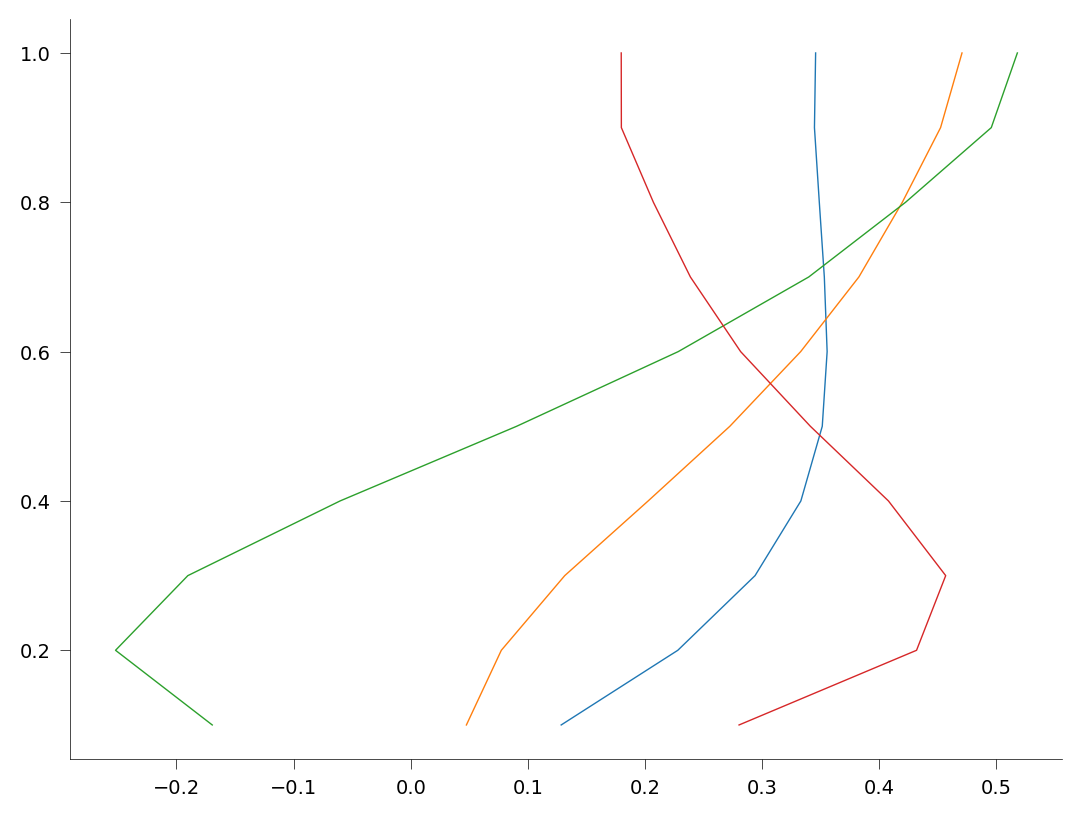

In [352]:
for i in range(4):
    plt.plot(norm_cluster_mean[i], var[key][0].isel(pnorm=slice(1, 9999)).pnorm)
# plt.plot(norm_cluster_mean[1], var[key][0].isel(pnorm=slice(1, 9999)).pnorm)
# plt.plot(-initial_cluster_mean[1], var[key][0].isel(pnorm=slice(1, 9999)).pnorm)

In [260]:
norm_reduction

array([[8.32210684e-01, 2.06475629e-03, 9.48468142e-03, 2.45623096e-03],
       [7.40419375e-01, 3.38741537e-02, 3.68003576e-05, 8.37276564e-05],
       [7.16037903e-01, 3.83403287e-02, 2.61801690e-05, 2.64717131e-03],
       ...,
       [8.37284404e-01, 9.81813419e-03, 1.09063138e-03, 1.52406399e-05],
       [6.35205100e-01, 5.37386641e-02, 1.12590378e-02, 3.65775616e-04],
       [9.05576734e-01, 5.79637442e-04, 5.06713174e-05, 2.71867638e-03]])

In [259]:
(cluster_ind == 0).sum() / cluster_ind.size * 100

88.02071849597978

In [227]:
np.linalg.norm(x_residual, axis=1)

array([[ 4.95517494, 29.4711477 , 29.25202154, 29.45958662],
       [ 7.93275066, 29.52468215, 30.55874734, 30.55731325],
       [ 5.39667748, 18.27626693, 19.00442433, 18.95461259],
       [11.01855292, 33.42216384, 34.99126639, 35.04192924],
       [ 3.79485665, 29.8214988 , 30.01076509, 30.01898982],
       [ 5.67080353, 45.27747822, 45.50190452, 45.45119539],
       [ 9.02705178, 22.71473609, 21.32355534, 22.74806681],
       [ 9.5004442 , 43.04268216, 43.96560384, 43.9267699 ],
       [ 8.72149068, 25.38228629, 26.57445037, 26.32818516],
       [ 9.76117183, 17.83999499, 19.52480087, 19.8596234 ],
       [14.63776324, 44.28868812, 46.52671798, 46.45962157],
       [10.12360501, 24.35861225, 26.16948045, 26.23868728],
       [19.78011925, 29.55915417, 34.42493602, 34.98811092],
       [18.99111567, 30.39620585, 34.68807637, 34.68960644],
       [13.65005276, 16.61482532, 19.79962645, 19.87536693],
       [ 5.41565639, 24.76191958, 24.93870675, 25.09808582],
       [12.32258273, 26.

In [223]:
(coef[:, np.newaxis] * norm_cluster_mean.transpose()[np.newaxis]).shape

(20, 10, 4)

In [217]:
coef * norm_cluster_mean

ValueError: operands could not be broadcast together with shapes (20,4) (4,10) 

In [214]:
x_norm

array([29.53212434, 30.55987195, 19.00492188, 35.07323522, 30.02948329,
       45.5264934 , 22.86480746, 43.98114772, 26.57458504, 19.86419381,
       46.54209653, 26.24016757, 34.98928366, 35.04270537, 20.20327464,
       25.12280768, 28.66960212, 51.58733337, 39.39083141,  4.3288437 ])

In [21]:
def make_coefs_sparse(profiles, pca_comp, pca_coef, pca_std, error_thresh=1):
    error_initial = np.sqrt(((profiles - (pca_comp * pca_coef).sum(dim='mode') * pca_std) ** 2).sum(dim='logp_rel'))
    n_mode = pca_comp.mode.size
    pca_coef_out = pca_coef * 1
    for i in range(n_mode):
        pca_coef_use = pca_coef.where(pca_coef.mode != i, 0)
        error_use = np.sqrt(((profiles - (pca_comp * pca_coef_use).sum(dim='mode') * pca_std) ** 2).sum(dim='logp_rel'))
        make_sparse = error_use - error_initial < error_thresh
        make_sparse = make_sparse & (pca_coef.mode == i)  # want to just make the current coefficient 0
        pca_coef_out = pca_coef_out.where(~make_sparse, 0)
    return pca_coef_out


# where coefficients are not important, set the coefficient to 0 i.e. ensure sparsity
if int((pca_output[1] == 0).sum()) == 0:
    pca_output[1] = make_coefs_sparse(var[0], pca_output[0], pca_output[1], pca_output[3], error_thresh=1)

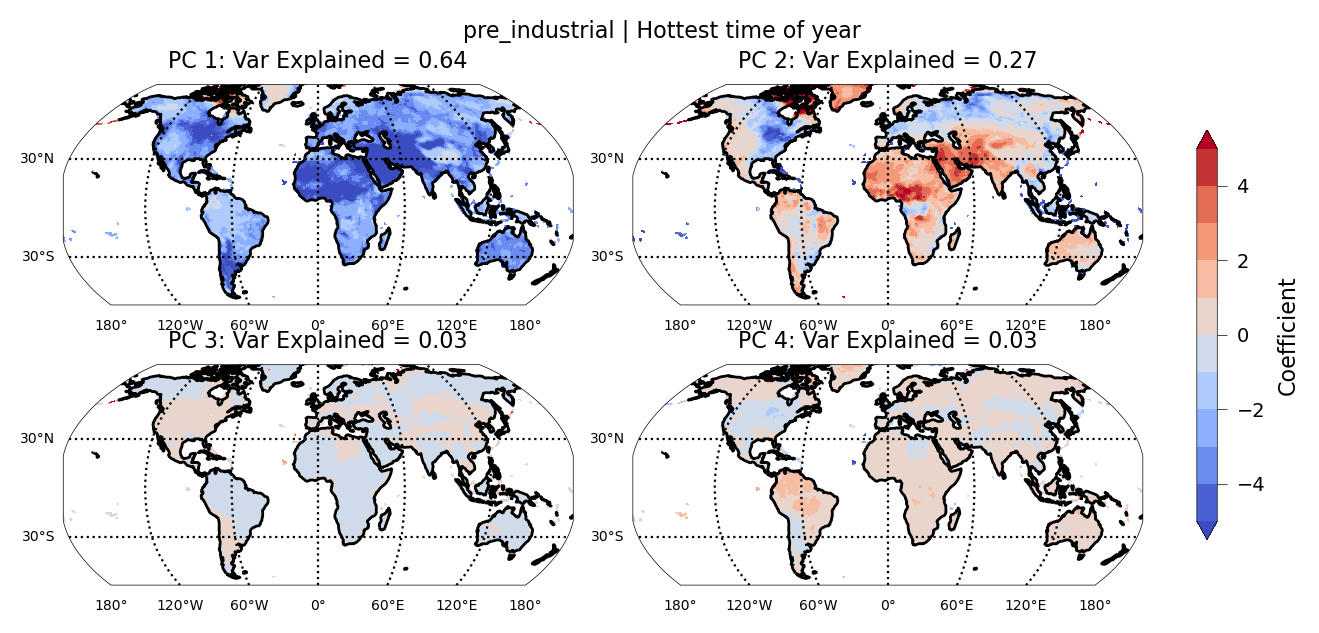

In [37]:
co2_ind = 0
levels_use = np.arange(-5, 6, 1)
fig = plt.figure(constrained_layout=True, figsize=(6.5, 3))
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
for i, ax_use in enumerate(ax.flatten()):
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = plot_contour_projection(ax_use, pca_output[1].isel(co2=co2_ind, mode=i).mean(dim='sample'),
                                 cmap='coolwarm', levels=levels_use,
                                 mask=lsm)
    ax_use.set_title(f'PC {i + 1}: Var Explained = {pca_output[-1][i]:.2f}')
fig.colorbar(shrink=0.8, ax=ax.ravel(), label='Coefficient', mappable=im)
fig.suptitle(f'{exp_name[co2_ind]} | Hottest time of year', fontsize=8)
# isca_tools.savefig(fig)
plt.show()

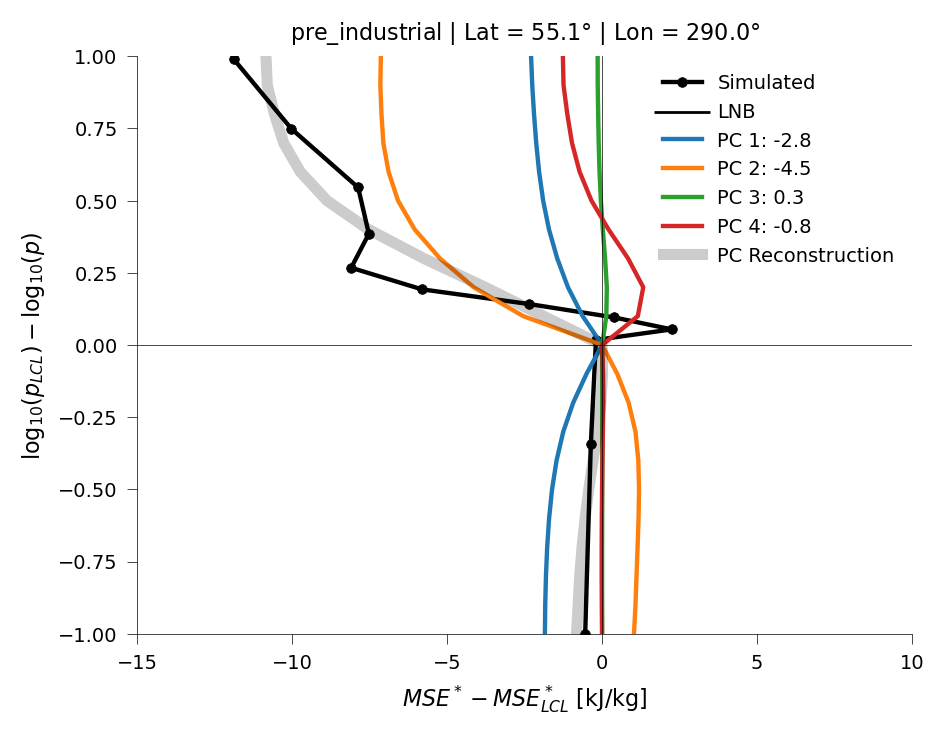

In [50]:
# coord_use = {'co2': 0, 'lat': 25, 'lon': 50}            # Persian gulf
# coord_use = {'co2': 0, 'lat': 28, 'lon': 50}  # Persian gulf coast
# coord_use = {'co2': 0, 'lat': -85, 'lon': 100}          # Antarctic, hard test
# coord_use = {'co2': 0, 'lat': 51, 'lon': 90}            # Tibet
coord_use = {'co2': 0, 'lat': 55, 'lon': 290}  # Canada
coord_use['sample'] = 0
ds_use = ds.isel(co2=coord_use['co2'], sample=coord_use['sample']).sel(lat=coord_use['lat'], lon=coord_use['lon'],
                                                                       method='nearest')  # Canada
pc_coefs_use = pca_output[1].isel(co2=coord_use['co2'], sample=coord_use['sample']
                                  ).sel(lat=coord_use['lat'], lon=coord_use['lon'], method='nearest')

p_max = 30 * 100
# p_max = 200 * 100

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)

# var, var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)
mse_prof_use, mse_lcl_use = get_mse_prof(ds_use.T, ds_use.P, ds_use.Z3,
                                         ds_use[f'T_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use[f'Z_at{lcl_use}'])
pnorm_use = get_pnorm(ds_use.P, ds_use[f'p{lcl_use}'], ds_use.PREFHT, p_ft).where(ds_use.P >= p_max)
ax.plot((mse_prof_use - mse_lcl_use).where(ds_use.P >= p_max),
        pnorm_use, marker='o', color='k',
        markersize=3.5,
        label='Simulated')
ax.scatter(mse_prof_use.isel(lev=ds_use.lnb_ind) - mse_lcl_use,
           get_pnorm(ds_use.P.isel(lev=ds_use.lnb_ind), ds_use[f'p{lcl_use}'], ds_use.PREFHT, p_ft),
           marker='_', s=400, lw=1, color='k', label='LNB')
for i in range(n_modes):
    if pc_coefs_use.isel(mode=i) == 0:
        continue
    ax.plot(pca_output[0].isel(mode=i) * pc_coefs_use.isel(mode=i) * pca_output[3], pca_output[0].pnorm,
            color=f'C{i}',
            label=f'PC {i + 1}: {pc_coefs_use[i]:.1f}')
update_linewidth(fig)
ax.plot((pca_output[0] * pc_coefs_use * pca_output[3]).sum(dim='mode'), pca_output[0].pnorm, color='k', alpha=0.2,
        lw=4, label='PC Reconstruction')
#
# var = \
# interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind,
#                    logp_custom_grid=logp_grid)[0]
# var = var.isel(logp_rel=slice(1, 9999))
# error = np.sqrt(((var - (pca_output[0] * pc_coefs_use * pca_output[3]).sum(dim='mode')) ** 2).sum(dim='logp_rel'))

# ax[1].plot(var, var.logp_rel, marker='|', markersize=10, color='C0', label='Interpolated')
# ax[1].set_xlim(ax[1].get_xlim()[0], 20)

# for i in range(2):
# update_linewidth(fig)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
# ax[0].legend()
# ax[0].set_xlabel('$T - T_{LCL}$ [K]')
# ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
# ax[0].set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.set_ylim(-1, 1)
ax.set_xlim(-15, 10)
ax.legend()
ax.set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax.set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.set_title(
    f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$")
plt.show()

## Reconstructing $T_{LCL}$
From the PC decomposition, we can reconstruct for each location $\epsilon = h_{LCL}^* - h_{FT}^* \approx -\sum_i x_i \chi_i(p_{FT})$

where $x$ is the coefficient at that location, and $\chi$ is the PC (same for all locations), and $i$ refers to the PC number.

After finding $\epsilon$, we can use our $z$ approximation to find an estimate for $T_{LCL}$ and the contribution from each PC.

In [24]:
p_ft = 500 * 100
ds['T_ft'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), float(ds.P0.isel(co2=0)),
                                       np.atleast_1d(p_ft), lev_dim='lev').load()
ds['Z_ft'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), float(ds.P0.isel(co2=0)),
                                       np.atleast_1d(p_ft), lev_dim='lev').load()
ds['mse_sat_ft'] = moist_static_energy(ds.T_ft, sphum_sat(ds.T_ft, p_ft), ds.Z_ft)

# Find value of each PC at p_ft i.e. where LCL closer to p_ft, expect indices to be closer to 0
p_pca_env = ds[f'p{lcl_use}'] * 10 ** (-pca_output[0].logp_rel)  # pressures used for PC finding at each lat, lon
# Remember to multiply by std_dev at each level pca_output[3] to give each PC at FT level for each location
pca_ft_val = get_var_at_plev(pca_output[0] * pca_output[3], p_pca_env,
                             p_ft, lev_dim='logp_rel', method='linear')

epsilon_from_pca = (-pca_ft_val * pca_output[1]).sum(dim='mode')  # multiply PC at p_ft by the PC coefficient
temp_at_lcl_theory = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                           pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=epsilon_from_pca)

Reversed order of logp_rel for interpolation so p_env is ascending


### $\epsilon$ sanity check
Below we confirm the $\epsilon$ computed from PCs match the simulated value. We mask locations where $p_{LCL} < p_{FT}$ e.g. Tibet.

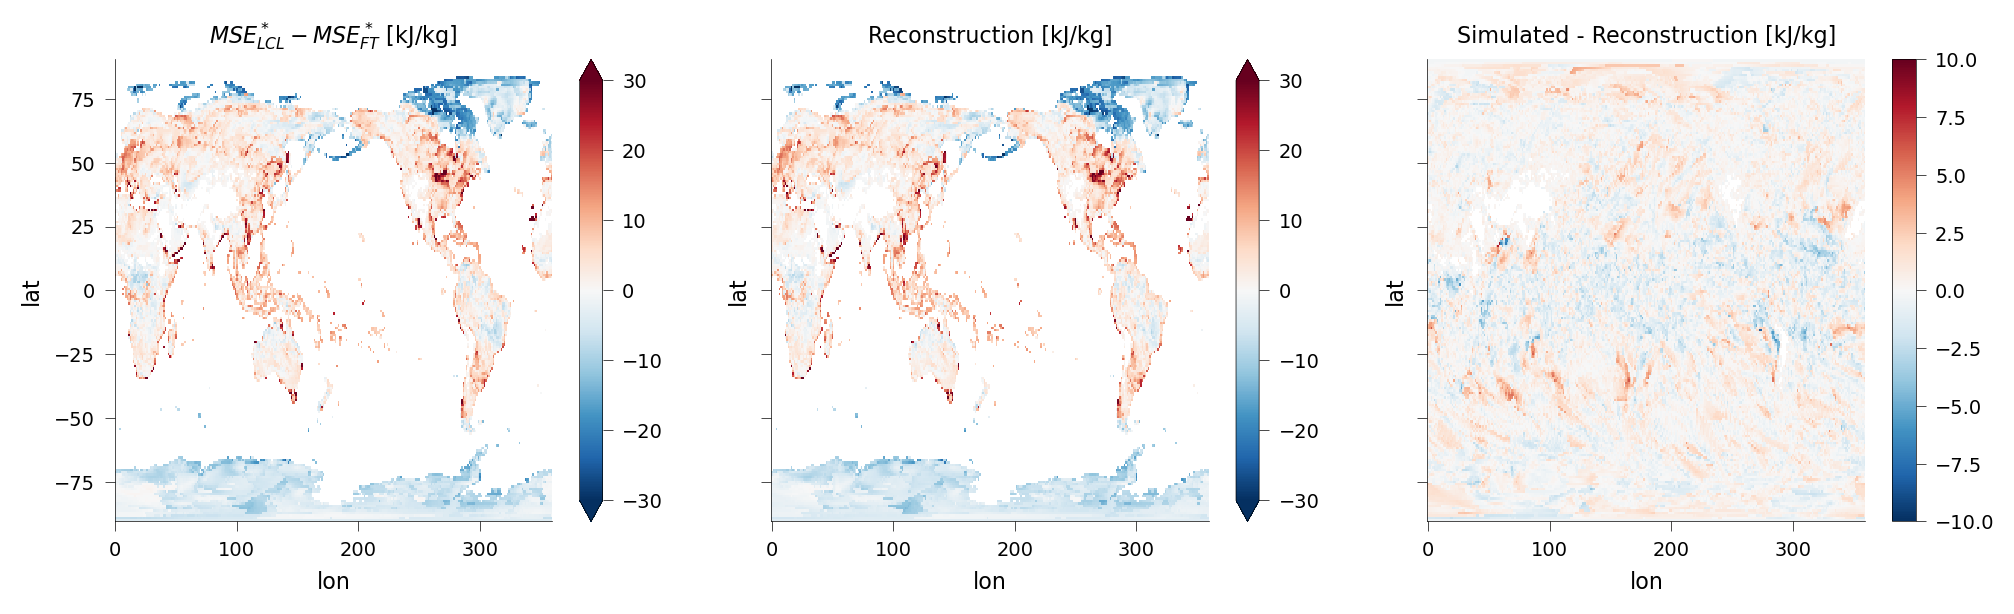

In [83]:
co2_ind = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
epsilon = ds['mse_sat_at_lcl'] - ds['mse_sat_ft']
epsilon.where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-30, ax=ax[0])
epsilon_from_pca.where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-30, ax=ax[1])
(epsilon - epsilon_from_pca).where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).plot(vmin=-10, ax=ax[2])
ax[0].set_title('$MSE_{LCL}^* - MSE_{FT}^*$ [kJ/kg]')
ax[1].set_title('Reconstruction [kJ/kg]')
ax[2].set_title('Simulated - Reconstruction [kJ/kg]')
plt.show()

### $T_{LCL}$ sanity check
Below, we compare the reconstructed LCL temperature from the PCs to the simulated value.

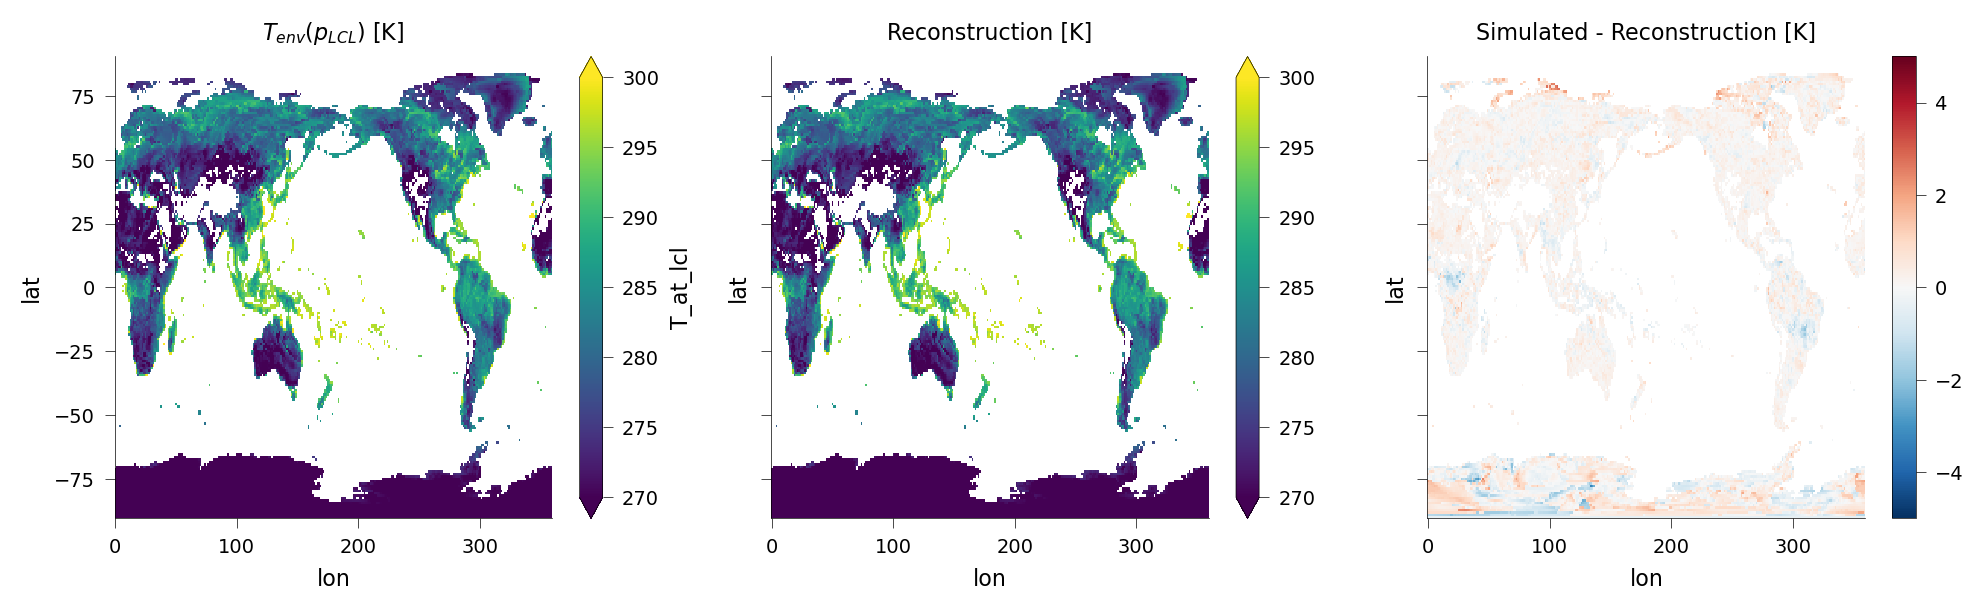

In [30]:
co2_ind = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
ds[f'T_at{lcl_use}'].where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300, ax=ax[0])
temp_at_lcl_theory.where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300, ax=ax[1])
(ds[f'T_at{lcl_use}'] - temp_at_lcl_theory).where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-5,
                                                                                                              ax=ax[2])
ax[0].set_title('$T_{env}(p_{LCL})$ [K]')
ax[1].set_title('Reconstruction [K]')
ax[2].set_title('Simulated - Reconstruction [K]')
plt.show()

In [ ]:
temp_at_lcl_no_epsilon = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                               pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=0)

In [ ]:
temp_at_lcl_theory_cont = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                                pressure_surf=ds[f'p{lcl_use}'], rh_form=True,
                                                epsilon=-pca_ft_val * pca_output[1]) - \
                          temp_at_lcl_no_epsilon

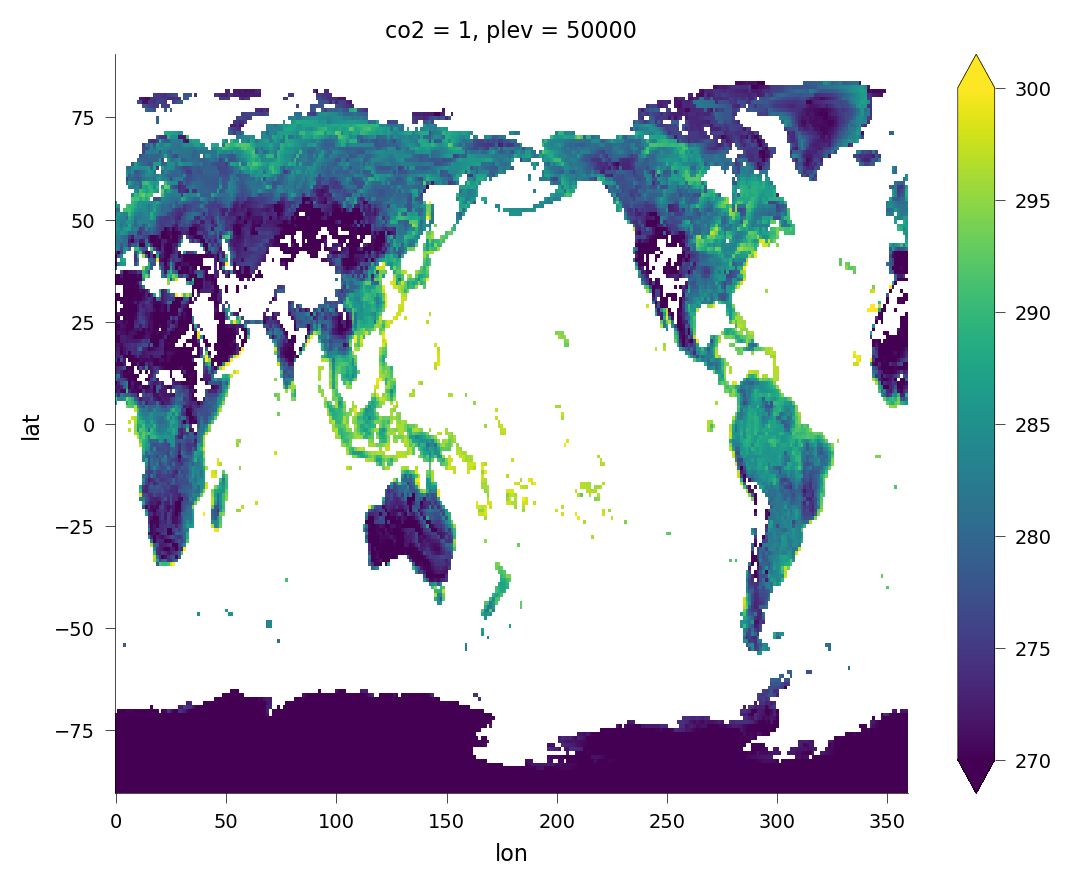

In [46]:
# If linear approx ok, should look like temp_at_lcl above
(temp_at_lcl_no_epsilon + temp_at_lcl_theory_cont.sum(dim='mode')
 ).isel(co2=0).where(ds[f'p{lcl_use}'] > p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300)

In [27]:
mask_ref = lsm & (lsm.lat > -60) & (lsm.lat < 80) & (ds[f'p{lcl_use}'] > 1.2 * p_ft)

In [28]:
mask_ref = lsm & (lsm.lat > -60) & (lsm.lat < 80) & (ds[f'p{lcl_use}'] > 1.2 * p_ft)
temp_ft_ref = ds.T_ft.where(mask_ref).mean(dim=['lat', 'lon', 'plev'])
p_lcl_ref = ds[f'p{lcl_use}'].where(mask_ref).mean(dim=['lat', 'lon', 'co2'])
epsilon_ref = 0
temp_at_lcl_ref = get_temp_adiabat_surf(1, temp_ft_ref, z_ft=None, pressure_ft=p_ft,
                                        pressure_surf=p_lcl_ref, rh_form=True, epsilon=epsilon_ref)

In [33]:
temp_at_lcl_no_epsilon = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                               pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=0)

In [34]:
temp_at_lcl_theory_cont = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                                pressure_surf=ds[f'p{lcl_use}'], rh_form=True,
                                                epsilon=-pca_ft_val * pca_output[1]) - \
                          temp_at_lcl_no_epsilon

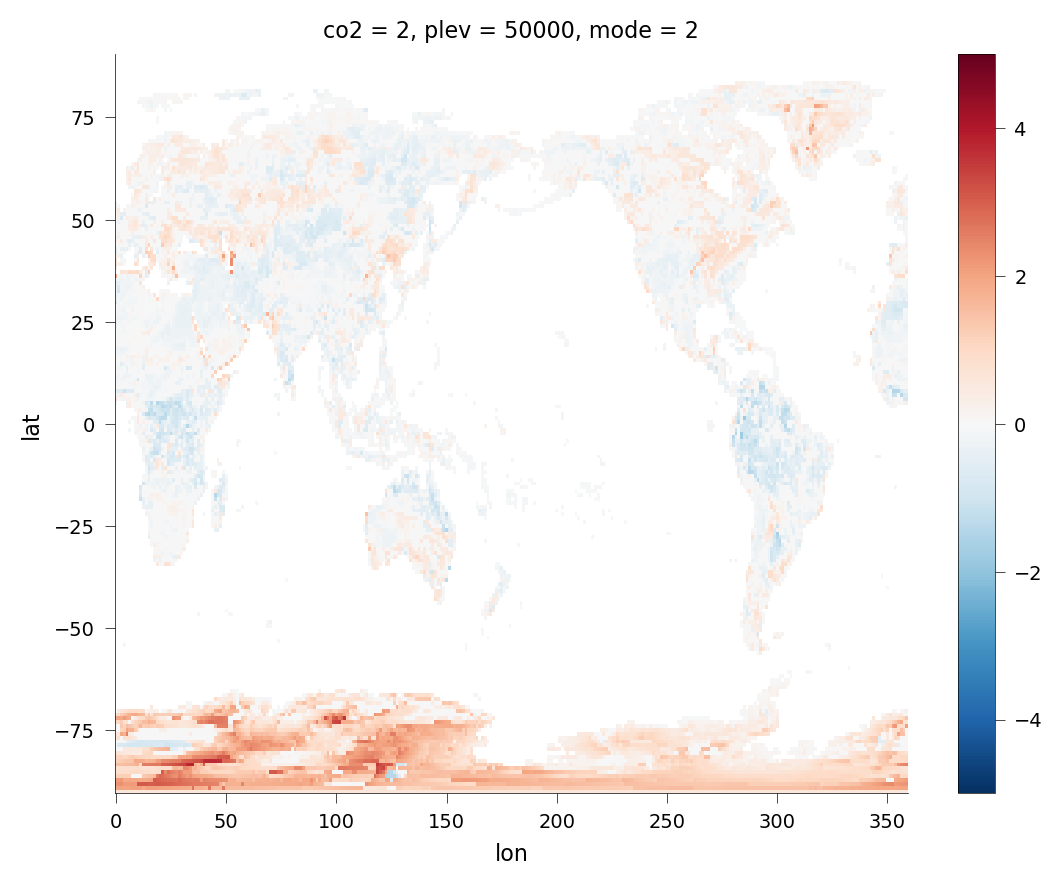

In [91]:
temp_at_lcl_theory_cont.isel(mode=2, co2=1).where(lsm).plot(vmax=5)

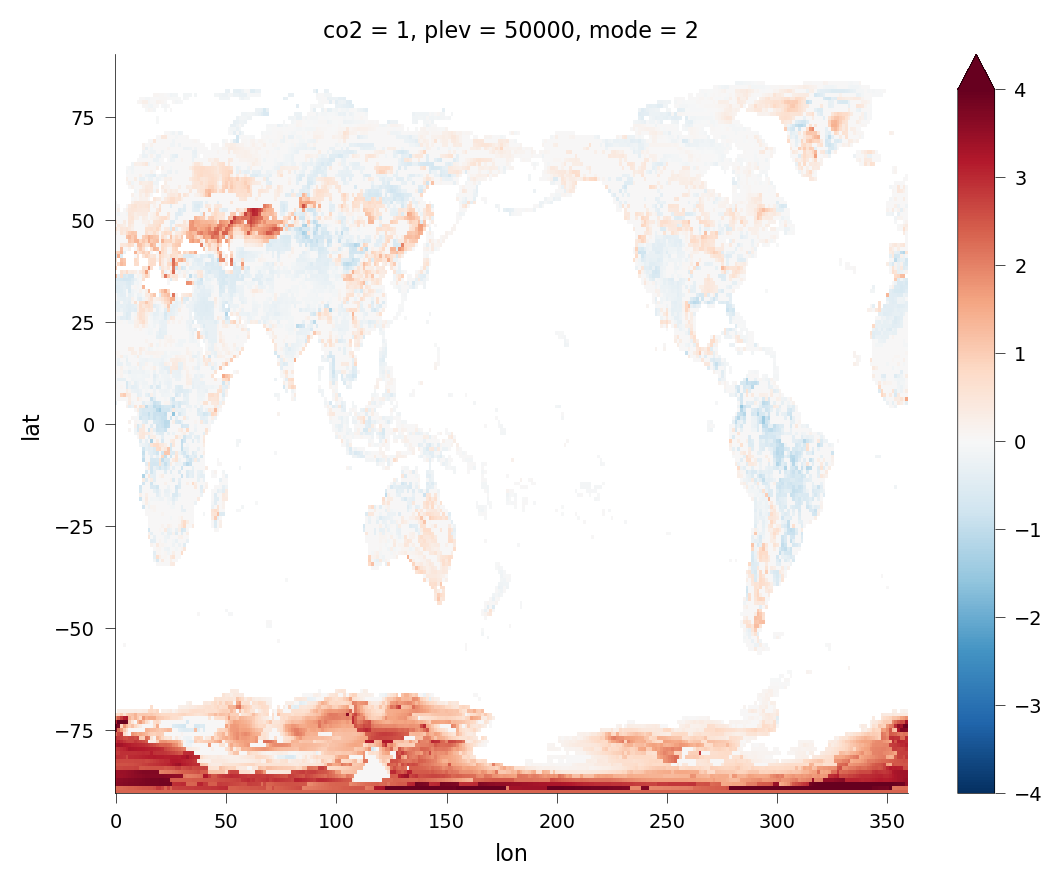

In [79]:
temp_at_lcl_theory_cont.isel(mode=2, co2=0).where(lsm).plot(vmax=4)

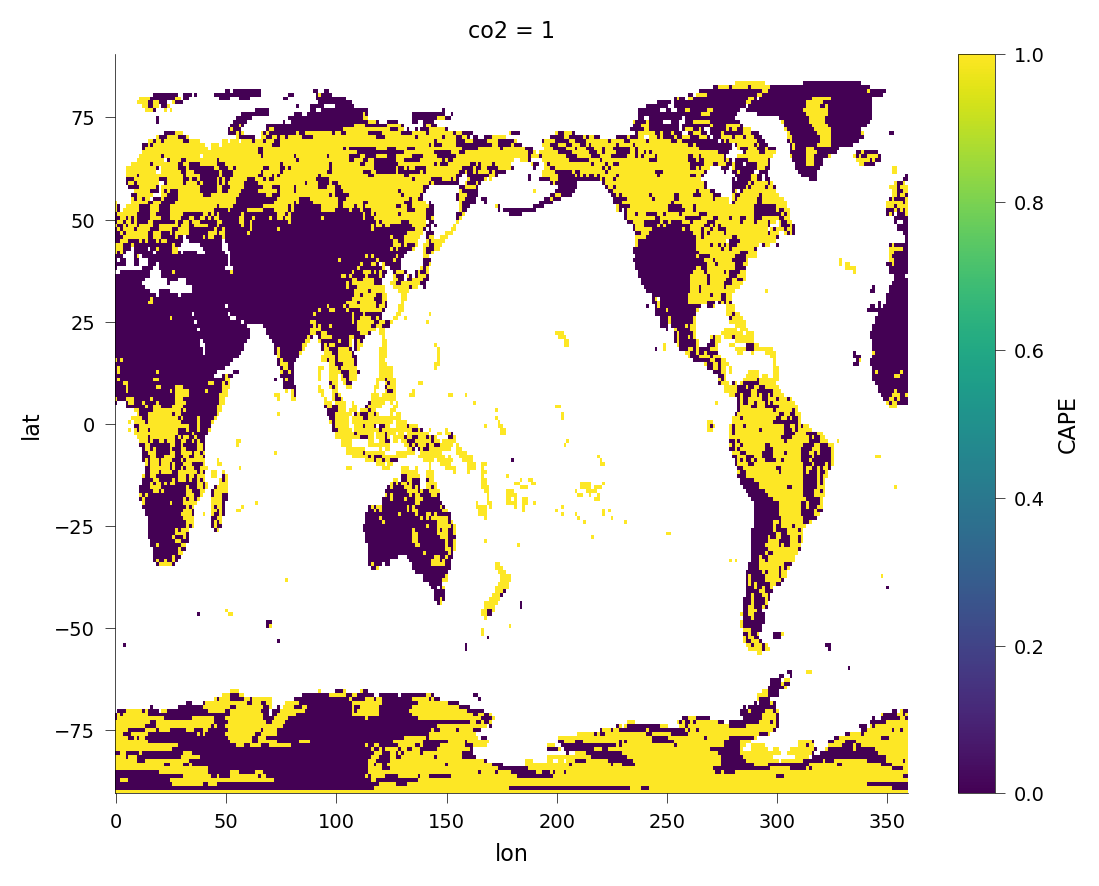

In [58]:
(ds.CAPE.isel(co2=0) > 10).where(lsm).plot()

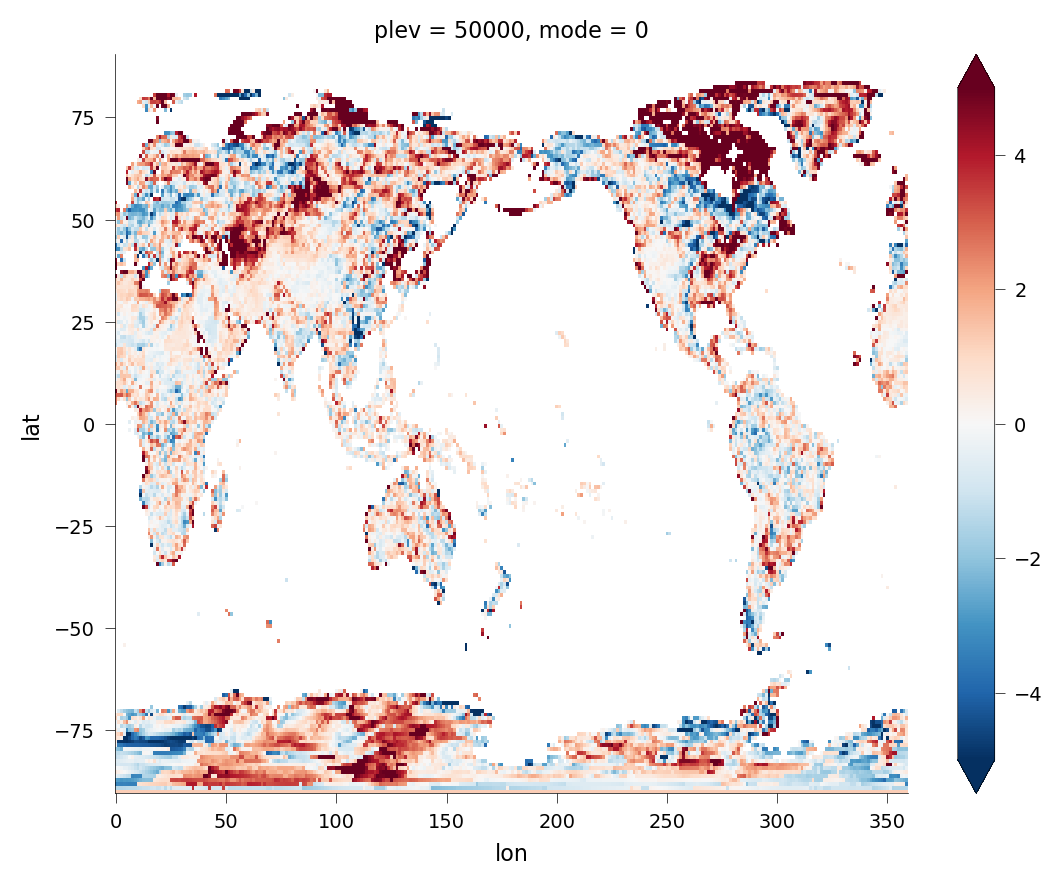

In [82]:
(temp_at_lcl_theory_cont.isel(mode=0, co2=1) - temp_at_lcl_theory_cont.isel(mode=0, co2=0)).where(lsm).plot(vmax=5)